# Download  Dataset

In [ ]:
# download the data from the github data source
! git clone https://github.com/MilaNLProc/translation_bias.git

Cloning into 'translation_bias'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 27 (delta 0), reused 27 (delta 0), pack-reused 0
Receiving objects: 100% (27/27), 3.95 MiB | 14.51 MiB/s, done.


# Load Data

In [ ]:
import pandas as pd

# load .xlsx using pandas read_excel()
df_train = pd.read_excel("/content/translation_bias/data/en_us/en_us_TRAIN.xlsx")
df_test = pd.read_excel("/content/translation_bias/data/en_us/en_us_TEST.xlsx")

# view top 2 rows from the data
df_train.head(2)

,Unnamed: 0,text,age,age_cat,gender,label
0,238,Not the best overall service.,42,25-54,M,train
1,239,Since it is the #1 social network however with...,42,25-54,M,train


# Data Preparing

In [ ]:
# Drop duplicates and Nan data
print("Before dropping:")
print(len(df_train))
df_train.isnull().values.any()
df_train = df_train.drop_duplicates()
df_train = df_train[df_train['text'].notna()]

print("After dropping:")
print(len(df_train))

# drop unamed column
df_test.drop(["Unnamed: 0"], axis=1, inplace=True)
df_train.drop(["Unnamed: 0"], axis=1, inplace=True)

# renaming columns
df_train.rename(columns={'label': 'data_for','age_cat':'ageRange'}, inplace=True)
df_test.rename(columns={'label': 'data_for','age_cat':'ageRange'}, inplace=True)

# Convert the string labels to Categorical label
gender_label_map = {
    "F": 0,
    "M": 1
}

df_train["label"] = df_train['gender'].map(gender_label_map)
df_test["label"] = df_test['gender'].map(gender_label_map)

Before dropping:
5004
After dropping:
4996


In [ ]:
df_train.head(2)

,text,age,ageRange,gender,data_for,label
0,Not the best overall service.,42,25-54,M,train,1
1,Since it is the #1 social network however with...,42,25-54,M,train,1


# Lexical baseline model
[Paper](https://aclanthology.org/P19-1246.pdf) <br>
1. A bag-of-word (BOW) representation of the text including all the words in the corpus.
2. Extract (3-6) word and character ngrams without pre-processing.
3. Feed these features to a Logistic Regression model(train the model on 80% of the data, and test it on the remaining 20%)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack


In [ ]:
corpus = df_train.text.values
labels = df_train.label.values

In [ ]:
# TEST CountVectorizer word tokenizer
# Note: CountVectorizer excludes character len of 1 as it doesn't consider them as word n uses: \b\w\w+\b . Solution is to use own pattern like (?u)\b\w+\b

# v = CountVectorizer(ngram_range=(3, 6),token_pattern = r"(?u)\b\w+\b",analyzer='word')
# for i in v.fit(["an apple a day keeps the doctor away"]).vocabulary_:
#   print(i)

# TEST CountVectorizer char tokenizer
# v = CountVectorizer(ngram_range=(3, 6), analyzer='char')
# print (v.fit(["an apple a day keeps the doctor away"]).vocabulary_)

# Vectorize Text

In [ ]:
# CountVectorizers for word and character ngrams
vectorizer_char = CountVectorizer(ngram_range=(3, 6), analyzer='char')
vectorizer_word = CountVectorizer(ngram_range=(3, 6),token_pattern = r"(?u)\b\w+\b", analyzer='word')

# Fit and transform the corpus using both vectorizers
X_char = vectorizer_char.fit_transform(corpus)
X_word = vectorizer_word.fit_transform(corpus)

# Combine character and word ngrams features
X = hstack([X_char, X_word]) # hstack() is used to stack or arrange arrays in sequence horizontally (column-wise)

<4996x1382642 sparse matrix of type '<class 'numpy.int64'>'
	with 5998248 stored elements in Compressed Sparse Row format>

# Train Logistic Regression Model

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

In [ ]:
# Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

In [ ]:
# Predict and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.642
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       495
           1       0.64      0.67      0.65       505

    accuracy                           0.64      1000
   macro avg       0.64      0.64      0.64      1000
weighted avg       0.64      0.64      0.64      1000



# Measuring linguistic style

LIWC:
1. Text->POS whole data
2. filter LIWC categories
3. sklearn vectorizer BOW
5. train sklearn logistic reg a classifier on filtered words
6. 10 words with strongest weights

# Load Libraries

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Download necessary NLTK resources


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True


# Define LIWC categories based on POS tags
The **nine LIWC-derived categories** are: articles, auxiliary verbs, conjunctions, high-frequency adverbs, impersonal pronouns, negations, personal pronouns, prepositions, and quantifiers.



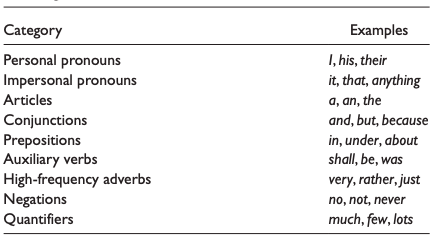

src: Molly E. Ireland, Richard B. Slatcher, Paul W. Eastwick, Lauren E. Scissors, Eli J. Finkel, and James W. Pennebaker. 2011. Language style matching predicts relationship initiation and stability. Psychological Science, 22:39–44.

In [ ]:
liwc_categories = {
    'articles': ['DT'],  # Determiner
    'auxiliary_verbs': ['MD', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],  # Modal/Auxiliary verbs
    'conjunctions': ['CC'],  # Coordinating conjunction
    'high_freq_adverbs': ['RB', 'RBR', 'RBS'],  # Adverbs
    'impersonal_pronouns': ['PRP$', 'WP$', 'WP'],  # Impersonal pronouns
    'negations': ['RB'],  # since 'not', 'never' are adverbs
    'personal_pronouns': ['PRP'],  # Personal pronouns
    'prepositions': ['IN'],  # Prepositions
    'quantifiers': ['CD', 'PDT']  # Cardinals, Predeterminers
}

# Extract LIWC words

In [ ]:
corpus = df_train.text.values
labels = df_train.label.values

In [ ]:
def extract_liwc_words(text):
    """
      Extract words based on LIWC categories
    """
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    liwc_words = []
    for word, tag in pos_tags:
        for category, tags in liwc_categories.items():
            if tag in tags:
                liwc_words.append(word)
                break
    return ' '.join(liwc_words)

vectorizer = CountVectorizer()

liwc_corpus = [extract_liwc_words(doc) for doc in corpus]
X = vectorizer.fit_transform(liwc_corpus)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)


# Train Logistic Regression Model

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

# Predict and evaluate the model

In [ ]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)



Accuracy: 0.607
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.55      0.58       495
           1       0.60      0.66      0.63       505

    accuracy                           0.61      1000
   macro avg       0.61      0.61      0.61      1000
weighted avg       0.61      0.61      0.61      1000



# Top 10 words with the strongest weights


In [ ]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['00', '000', '0005963490', ..., 'zazzle', 'zero', 'zylnn'],
      dtype=object)

In [ ]:
coefs = model.coef_[0] # We need coef_[0] to access the model's coefficients because the coef_ attribute returns a 2D array where each row corresponds to a class and each column corresponds to a feature.
coefs

array([ 0.2617671 ,  0.11303786,  0.        , ..., -0.13054829,
       -0.2669262 , -0.08444388])

In [ ]:
# top10_indices = np.argsort(np.abs(coefs))[-10:] #np.argsort sorts the value and returns the index in ascending order so we take the tail
top10_indices = np.argsort((coefs))[-10:] # without np.abs
# In NumPy, the .abs() function calculates the absolute value of a given number or each element in an array. The absolute value of a number is its non-negative value or the number's distance from zero.
top10_indices

array([1459, 1648, 1442,  421, 3402, 4122, 2850, 1873, 4327, 2296])

In [ ]:
top10_words = feature_names[top10_indices]
top10_words

array(['dispatched', 'ensure', 'discounted', 'across', 'requested',
       'timely', 'overall', 'flawlessly', 'verify', 'install'],
      dtype=object)

In [ ]:
top10_weights = coefs[top10_indices]
top10_weights

array([1.10084915, 1.10716743, 1.16028976, 1.20639808, 1.25982213,
       1.35179202, 1.35394534, 1.37571162, 1.40107426, 1.6278037 ])

In [ ]:

print("\nTop 10 words with strongest weights and their weights:")
for word, weight in zip(top10_words, top10_weights):
    print(f"{word}: {weight}")


Top 10 words with strongest weights and their weights:
dispatched: 1.1008491516403387
ensure: 1.1071674276347623
discounted: 1.1602897578346536
across: 1.2063980751041599
requested: 1.2598221339819653
timely: 1.3517920243236954
overall: 1.3539453382414879
flawlessly: 1.3757116174384558
verify: 1.40107426170785
install: 1.6278037009894897
